## Exercise 2: Predicting Risk Levels in Attack Surface Management Data Using Time Series

This notebook demonstrates how to use data from your environment to predict future risk levels. If you have risk scores assigned to some vulnerabilities, or to assets in your environment, do you think you can predict what the future might look like based on these scores? And do you know what types of assets contribute most to your risk?

**What's the story?**

You are still a new analyst in your security operations center, but you now have a better idea of what assets are present in your environment. Your Chief Information Security Officer (CISO) asks you to help her understand the risk and attack surface exposure you carry in your organization. You start to wonder if you can use this data to understand your current risk levels and to predict what the future may hold. This requires some analytics!

### Steps we will take:
- Load and preprocess the data
- Explore key features
- Train and evaluate predictive models
- Forecast risk for new assets

## What model will we use?
For this exercise, we recognize that we are working with time series data, or data that is recorded over time intervals (such as a datapoint recorded once each day). We will use an ARIMA time series model to model this data. ARIMA stands for *AutoRegressive Integrated Moving Average*. It’s a way to understand patterns in time series data and to make predictions about future values based on these patterns. Let's break that down:

**AutoRegressive (AR):**

This part of the model looks at how the current value of the series relates to its past values.
Imagine you are trying to predict tomorrow's temperature based on the temperatures of the past few days. If it was getting warmer each day, you might expect that pattern to continue.

**Integrated (I):**

This aspect involves differencing the data to make it stationary. Stationary means that the statistical properties of the series like mean and variance are constant over time.
For example, if temperatures are increasing every year, you might look at the changes in temperature from day to day (instead of the raw temperatures) to remove that trend so that the data is easier to analyze.

**Moving Average (MA):**

The moving average part of the model considers the influence of past forecast errors on current values.
If you consistently predict too high or too low, this component helps adjust predictions based on those past errors.
In an ARIMA model, you are combining these three elements to create a formula that tries to explain the time series data. 

**Note: all time series models require some assumptions about your data to have been validated in order for the model to truly apply and be appropriate for modeling and predicting for your situation. For more information about these assumptions and about time series models, see a resource such as this:** https://otexts.com/fpp2/

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
# Load the dataset
# Adjust the file path as necessary
df = pd.read_csv('../data/attack_surface_management_data_part_3.csv')

# let's filter the data to just the vulnerabilities that are unpatched
df = df[df['patch_status'] == 'Unpatched']

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the average risk per day
daily_avg_risk = df.groupby(df['timestamp'].dt.date)['risk_score'].mean()

# Convert the resulting series to a DataFrame with a proper index
daily_avg_risk = daily_avg_risk.asfreq('D')  # Ensure we have the daily frequency


Let's hold back a week worth of data to see if our model can predict the risk scores!

In [12]:
training_data_size = int(len(daily_avg_risk) - 10)
training_data, test_data = daily_avg_risk[:training_data_size], daily_avg_risk[training_data_size:]

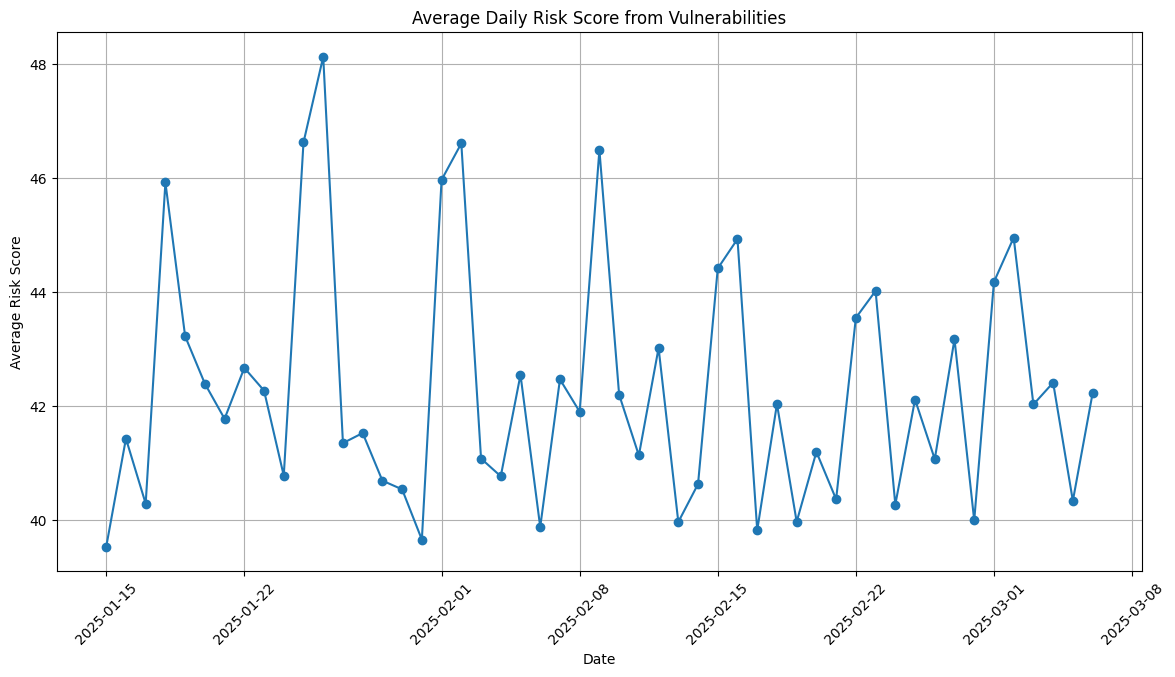

In [13]:

# Plotting the time series of average daily risk training data
plt.figure(figsize=(14, 7))
plt.plot(training_data.index, training_data.values, marker='o', linestyle='-')
plt.title('Average Daily Risk Score from Vulnerabilities')
plt.xlabel('Date')
plt.ylabel('Average Risk Score')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Remember what we saw previously. Do you see the same dip in average risk scores on some days in a predictable pattern?

In [ ]:
# Fit the ARIMA model (ensure your index is datetime with proper frequency)
model = ARIMA(training_data, order=(7, 1, 1))
model_fit = model.fit()

# Forecasting the next 7 days
forecast = model_fit.forecast(steps=10)
forecast_index = pd.date_range(start=training_data.index[-1] + pd.Timedelta(days=1), 
                                periods=10, freq='D')  # Ensure the frequency is daily

/Users/preeti/preeti_gh/ai_for_sec_workshop/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/preeti/preeti_gh/ai_for_sec_workshop/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


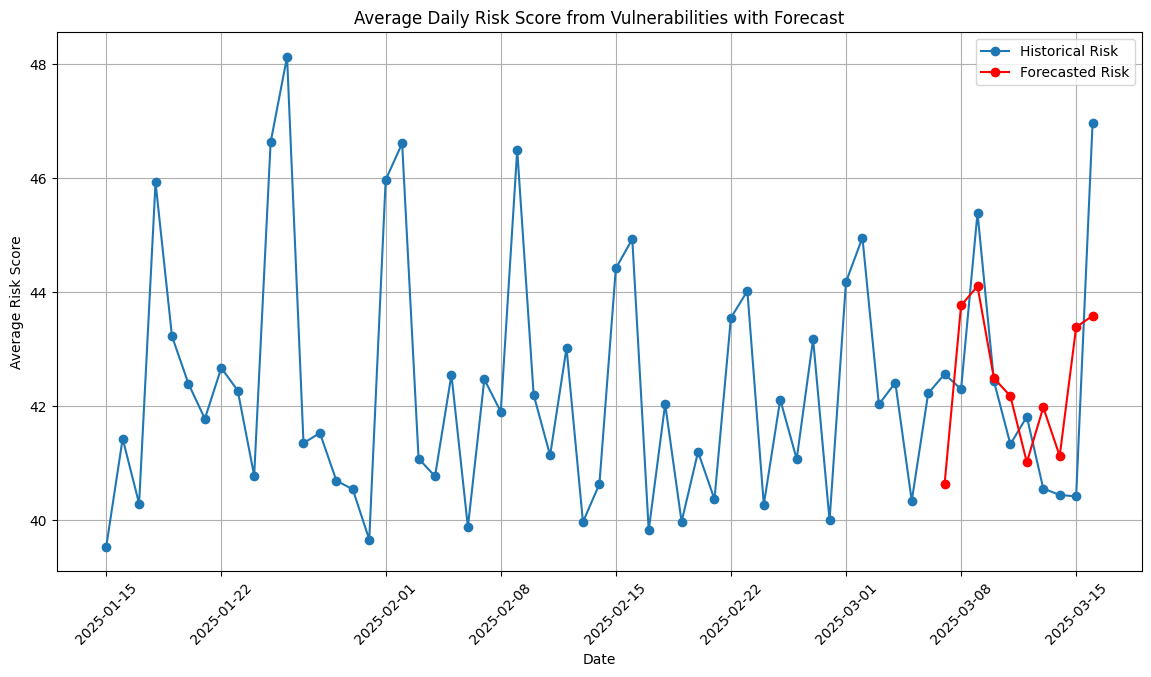

In [16]:

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_risk.index, daily_avg_risk.values, marker='o', linestyle='-', label='Historical Risk')
plt.plot(forecast.index, forecast, marker='o', linestyle='-', color='red', label='Forecasted Risk')
plt.title('Average Daily Risk Score from Vulnerabilities with Forecast')
plt.xlabel('Date')
plt.ylabel('Average Risk Score')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

Which asset types are associated with higher risk scores? Is it because we have more of those types of assets, or because they have vulnerabilities that are more critical?

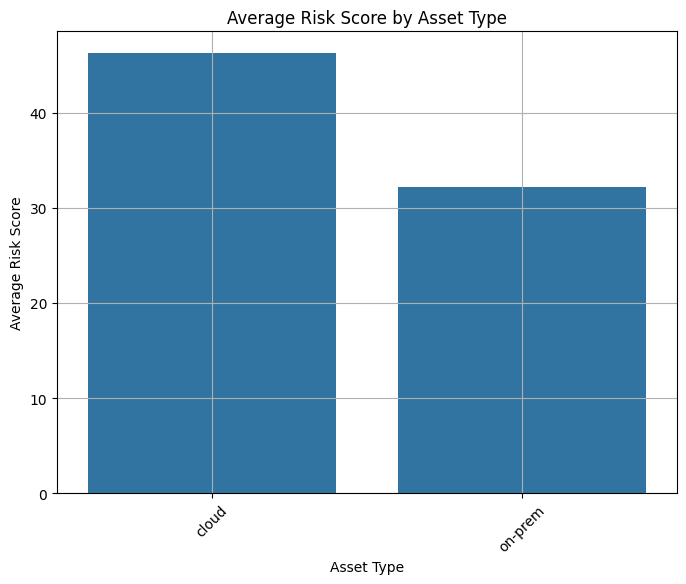

In [17]:
# Analyze risk by asset type
risk_by_asset_type = df.groupby('asset_type')['risk_score'].mean()

# Plotting risk by asset type
plt.figure(figsize=(8, 6))
sns.barplot(x=risk_by_asset_type.index, y=risk_by_asset_type.values)
plt.title('Average Risk Score by Asset Type')
plt.xlabel('Asset Type')
plt.ylabel('Average Risk Score')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [18]:
# How did our model do?
# Calculate errors
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Lower values represent a better fit!

MAE: 1.4845769830929663
MSE: 3.167027457345747
RMSE: 1.7796144125472089


In [ ]:
###

## Key Takeaways:
- **It is possible to predict the future using math models that aren't machine learning or AI models!**
- **In this exercise, there was more risk on average due to cloud assets**
- **Predictive models can forecast risk for new assets**

## What were our steps?
**We did some data cleaning, asked ourselves some critical questions about our data, and about what kind of model is appropriate, and fit the model. Once you fit a model, it's important to have some kind of method for figuring out if your predictions were accurate-- models can be updated with new data!**

## Food for Thought:

1. Why not GenAI for this? 
2. What can be changed in this approach?